In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from larcv import larcv
import math
%matplotlib inline
from tools import *

In [2]:
filename = '/Users/mdeltutt/Downloads/out_beam_3d_merged.h5.pkl'
df_3d = pd.read_pickle(filename)

filename = '/Users/mdeltutt/Downloads/out_beam_2d_merged.h5.pkl'
df_2d = pd.read_pickle(filename)

We are using a beam file, so pot (or weigth per event) has to be 1.

In [3]:
df_3d['pot'] = [1.] * len(df_3d)
df_2d['pot'] = [1.] * len(df_2d)
if len(df_3d) != len(df_2d):
    print('2d and 3d df have different size?')

Colors use to plot different categories,
`colors[]` is the matplotlib default color cycle

In [4]:
cat_color = {
        'nue'    : colors[3], # red
        'numu'   : colors[0], # blue
        'nc'     : colors[1]  # orange
    }

# Categories definition

Description of all the keys:
- *name*              : The name
- *signal_string*     : The truth-level signal selection string that can be used in a dataframe query()
- *background_string* : The truth-level background selection string that can be used in a dataframe query()
- *sel_string_reco*   : The reco-level signal selection string that can be used in a dataframe query()
- *label*             : The latex string with the signal name
- *bkgs_string*       : A list with all the different truth-level background selections (for different backgrounds)
- *all_labels*        : A list with all the latex string with the background names
- *colors*            : A list with all the colors to use for signal and all the backgrounds
- *nbins*             : The number of bins to use for plotting selected signal and background stacked
- *score*             : The score function to use to identify the best CNN output cut (fom, high_purity, high_efficiency, best_of_2d)

On the scores:
- *fom*: Calculates the FOM and picks the point of maximum
- *high_purity*: Fixes the purity at `_purity` (to be specified below) for both 2D and 3D
- *high_efficiency*: Fixes the efficiency at `_efficiency` (to be specified below) for both 2D and 3D
- *best_of_2d*: Picks the point of maximum for the best FOM of 2D, and then looks at the same FOM value for 3D.

In [21]:
categories = [
    {
        'name'              : "nue_cc",
        'signal_string'     : "true_neutrinoid == 0",
        'background_string' : "true_neutrinoid != 0",
        'sel_string_reco'   : "pred_neutrinoid_0",
        'label'             : r"$\nu_e$ CC",
        'bkgs_string'       : ['true_neutrinoid == 1', 'true_neutrinoid == 2'],
        'all_labels'        : [r'$\nu_e$ (signal)', r'$\nu_\mu$', r'$NC$'],
        'colors'            : [cat_color['nue'], cat_color['numu'], cat_color['nc']],
        'nbins'             : 15,
        'score'             : "fom",
        'folder'            : "paper_figures/nue_cc_inclusive"
    },
    {
        'name'              : "nue_cc_1p_0pi",
        'signal_string'     : "true_neutrinoid == 0 and true_prot == 1 and true_cpi == 0 and true_npi == 0",
        'background_string' : "true_neutrinoid != 0 or true_prot != 1 or true_cpi != 0 or true_npi != 0",
        'sel_string_reco'   : "pred_neutrinoid_0 * pred_prot1 * pred_cpino * pred_npino",
        'label'             : r"$\nu_e$ CC, $N_p$ = 1, $N_\pi$ = 0",
        'bkgs_string'       : ['true_neutrinoid == 0 and (true_prot != 1 or true_cpi != 0 or true_npi != 0)', 'true_neutrinoid == 1', 'true_neutrinoid == 2'],
        'all_labels'        : [r'$\nu_e$ CC, $N_p = 1$, $N_\pi = 0$ (signal)', r'$\nu_e$ CC other', r'$\nu_\mu$', r'$NC$'],
        'colors'            : [cat_color['nue'], lighten_color(cat_color['nue']), cat_color['numu'], cat_color['nc']],
        'nbins'             : 20,
        'score'             : "fom"
        ,
        'folder'            : "paper_figures/nue_cc_1p"
    },
    {
        'name'              : "nc_pi0",
        'signal_string'     : "true_neutrinoid == 2 and true_cpi == 0 and true_npi == 1",
        'background_string' : "true_neutrinoid != 2 or true_cpi != 0 or true_npi != 1",
        'sel_string_reco'   : "pred_neutrinoid_2 * pred_cpino * pred_npiyes",
        'label'             : r"$\nu$ NC $\pi^0$",
        'bkgs_string'       : ['true_neutrinoid == 2 and (true_cpi != 0 or true_npi != 1)', 'true_neutrinoid == 0', 'true_neutrinoid == 1'],
        'all_labels'        : [r'$\nu$ NC $\pi^0$ (signal)', r'NC other', r'$\nu_e$ CC', r'$\nu_\mu$ CC'],
        'colors'            : [cat_color['nc'], lighten_color(cat_color['nc']), cat_color['nue'], cat_color['numu']],
        'nbins'             : 20,
        'score'             : "fom",
        'folder'            : "paper_figures/nu_nc_pi0"
    },
    {
        'name'              : "numu_cc",
        'signal_string'     : "true_neutrinoid == 1",
        'background_string' : "true_neutrinoid != 1",
        'sel_string_reco'   : "pred_neutrinoid_1",
        'label'             : r"$\nu_\mu$ CC",
        'bkgs_string'       : ['true_neutrinoid == 0', 'true_neutrinoid == 2'],
        'all_labels'        : [r'$\nu_\mu$ (signal)', r'$\nu_e$', r'$NC$'],
        'colors'            : [cat_color['numu'], cat_color['nue'], cat_color['nc']],
        'nbins'             : 20,
        'score'             : "high_purity",
        'folder'            : "paper_figures/numu_cc_inclusive"
    }
]

_purity = 0.99
_efficiency = 0.85

Select the category to plot here:

In [35]:
c = categories[3]

In [36]:
this_max = 1000

def get_fom(sig_df, bkg_df, sel_string_reco):
    '''
    Calculates the figure of merit S/sqrt(S+B)
    given a dataframe containing all signal events
    and a dataframe containing all background events.
    sel_string_reco is used to apply the event selection.
    '''
    
    fom_y = []
    fom_x = []

    for x in range(this_max):
    
        th = (x/float(this_max))
    
        sel_sig_df = sig_df.query(sel_string_reco + " >= " + str(th))
        sel_bkg_df = bkg_df.query(sel_string_reco + " >= " + str(th))
        
        s = np.sum(sel_sig_df['pot'])
        b = np.sum(sel_bkg_df['pot'])
            
        fom = 0
        if b != 0:
            fom = s / math.sqrt(s + b)
        
        fom_x.append(th)
        fom_y.append(fom)

    return fom_x, fom_y

In [37]:
from sklearn.metrics import roc_curve, auc

def get_roc(df, signal_string):
    '''
    Returns the ROC curve for a given
    dataframe df and a truth-level event
    selection as specified in signal_string.
    '''

    idxs = df.query(signal_string).index
    y_true = [0]*len(df)
    y_true = np.asarray(y_true)
    y_true[idxs] = 1

    sel_df = [1] * len(df)
    for s in c['sel_string_reco'].split(' * '):
        sel_df *= df[s].values
        
    y_score = np.array(sel_df)

    fpr, tpr, roc_th = roc_curve(y_true, y_score, pos_label=1)

    fpr = 1 - fpr
        
    return fpr, tpr, roc_th


def find_nearest(array, value):
    '''
    Finds the index of the nearest number
    to value in a list or array.
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Selects the signal and background at truth level for both 2D and 3D.

In [38]:
sig_df_3d = df_3d.query(c['signal_string'])
bkg_df_3d = df_3d.query(c['background_string'])

sig_df_2d = df_2d.query(c['signal_string'])
bkg_df_2d = df_2d.query(c['background_string'])

## Best cut finding

Depending on the `score`, finds the best cut on the CNN output.

In [39]:
fom_x, fom_y_3d = get_fom(sig_df_3d, bkg_df_3d, c['sel_string_reco'])
fom_x, fom_y_2d = get_fom(sig_df_2d, bkg_df_2d, c['sel_string_reco'])
    
if c['score'] == 'fom':
    max_idx_3d = np.argmax(fom_y_3d)
    x_max_3d = fom_x[max_idx_3d]

    max_idx_2d = np.argmax(fom_y_2d)
    x_max_2d = fom_x[max_idx_2d]
    
if c['score'] == 'high_purity':
    fpr_3d, tpr_3d, roc_th_3d = get_roc(df_3d, c['signal_string'])
    fpr_2d, tpr_2d, roc_th_2d = get_roc(df_2d, c['signal_string'])
    
    max_idx_3d = find_nearest(fpr_3d, _purity)
    x_max_3d = roc_th_3d[max_idx_3d]

    max_idx_2d = find_nearest(fpr_2d, _purity)
    x_max_2d = roc_th_2d[max_idx_2d]
    
if c['score'] == 'high_efficiency':
    fpr_3d, tpr_3d, roc_th_3d = get_roc(df_3d, c['signal_string'])
    fpr_2d, tpr_2d, roc_th_2d = get_roc(df_2d, c['signal_string'])
    
    max_idx_3d = find_nearest(tpr_3d, _efficiency)
    x_max_3d = roc_th_3d[max_idx_3d]

    max_idx_2d = find_nearest(tpr_2d, _efficiency)
    x_max_2d = roc_th_2d[max_idx_2d]
    
#     max_idx_3d = find_nearest(tpr_2d, _efficiency)

if c['score'] == 'best_of_2d':
    # Get the max of the fom for 2D
    _, fom_y_2d = get_fom(sig_df_2d, bkg_df_2d, c['sel_string_reco'])
    max_idx_2d = np.argmax(fom_y_2d)
    fom_max_2d = fom_y_2d[max_idx_2d]
    
    # Get the same value of the fom in the 3D one, and find the cut for 3D
    fom_x, fom_y_3d = get_fom(sig_df_3d, bkg_df_3d, c['sel_string_reco'])
    fom_y_3d_ar = np.array(fom_y_3d)
    max_idx_3d = (np.abs(fom_y_3d_ar - fom_max_2d)).argmin()
    x_max_3d = fom_x[max_idx_3d]
    
print ('3D - Best th =', x_max_3d)
print ('2D - Best th =', x_max_2d)

# Final selected signal and background
sel_sig_df_3d = sig_df_3d.query(c['sel_string_reco'] + " >= " + str(x_max_3d))
sel_bkg_df_3d = bkg_df_3d.query(c['sel_string_reco'] + " >= " + str(x_max_3d))
    
sel_sig_df_2d = sig_df_2d.query(c['sel_string_reco'] + " >= " + str(x_max_2d))
sel_bkg_df_2d = bkg_df_2d.query(c['sel_string_reco'] + " >= " + str(x_max_2d))
    

3D - Best th = 0.9353534579277039
2D - Best th = 0.9595167636871338


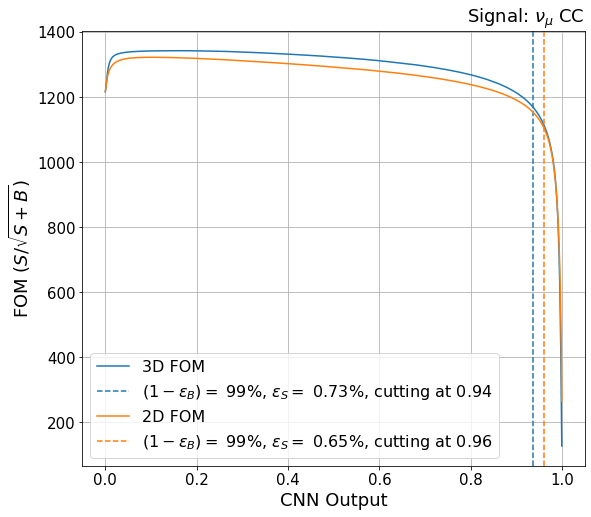

In [40]:
fig = plt.figure(figsize=(9,8),facecolor='w')
plt.figure(1)

plt.plot(fom_x, fom_y_3d, label='3D FOM')
if c['score'] == 'fom' or c['score'] == 'best_of_2d':
    l = r'Best 3D FOM ({0:0.1f}) obtained at {1:0.2f}'.format(fom_y_3d[max_idx_3d], x_max_3d)
else:
    l = r'$(1 - \epsilon_B) =$ {0:0.0f}%, $\epsilon_S =$ {1:0.2f}%, cutting at {2:0.2f}'.format(_purity*100, tpr_3d[max_idx_3d], x_max_3d)
plt.axvline(x_max_3d, color=colors[0], linestyle='--', label=l)

plt.plot(fom_x, fom_y_2d, label='2D FOM')
if c['score'] == 'fom' or c['score'] == 'best_of_2d':
    l = r'Best 2D FOM ({0:0.1f}) obtained at {1:0.2f}'.format(fom_y_2d[max_idx_3d], x_max_2d)
else:
    l = r'$(1 - \epsilon_B) =$ {0:0.0f}%, $\epsilon_S =$ {1:0.2f}%, cutting at {2:0.2f}'.format(_purity*100, tpr_2d[max_idx_2d], x_max_2d)
plt.axvline(x_max_2d, color=colors[1], linestyle='--', label=l)

plt.legend(fontsize=16, loc='best')
plt.ylabel(r'FOM ($S/\sqrt{S+B}$)',fontsize=18)
plt.xlabel('CNN Output',fontsize=18)
plt.title(r'Signal: '+c['label'], loc='right', fontsize=18)
plt.tick_params(labelsize=15)
plt.grid(True)

plt.savefig(c['folder']+'/fom_'+c['name']+'.pdf')
plt.show()

## ROC Curve

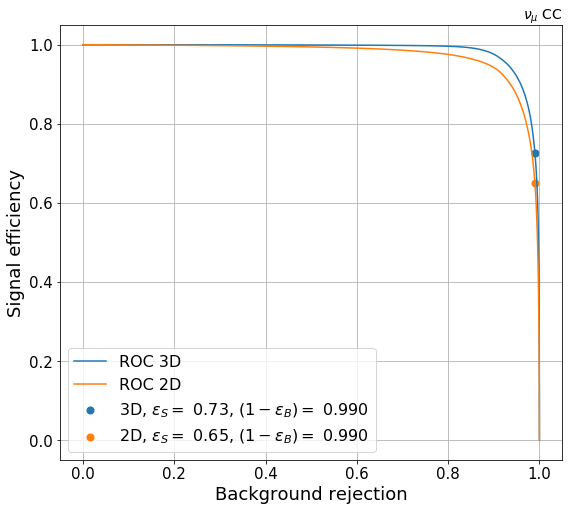

In [41]:
fpr_3d, tpr_3d, roc_th_3d = get_roc(df_3d, c['signal_string'])
fpr_2d, tpr_2d, roc_th_2d = get_roc(df_2d, c['signal_string'])

fig = plt.figure(figsize=(9,8),facecolor='w')
plt.figure(1)

idx_3d = find_nearest(roc_th_3d, x_max_3d)
idx_2d = find_nearest(roc_th_2d, x_max_2d)

fpr_best_3d = fpr_3d[idx_3d]
tpr_best_3d = tpr_3d[idx_3d]
fpr_best_2d = fpr_2d[idx_2d] 
tpr_best_2d = tpr_2d[idx_2d]

label= r'3D, $\epsilon_S =$ {0:0.2f}, $(1-\epsilon_B) =$ {1:0.3f}'.format(tpr_best_3d, fpr_best_3d)
plt.scatter(fpr_best_3d, tpr_best_3d, s=50, color=colors[0],label=label)
label= r'2D, $\epsilon_S =$ {0:0.2f}, $(1-\epsilon_B) =$ {1:0.3f}'.format(tpr_best_2d, fpr_best_2d)
plt.scatter(fpr_best_2d, tpr_best_2d, s=50, color=colors[1],label=label)

label='$\\nu_e$'
plt.plot(fpr_3d, tpr_3d, label='ROC 3D', color=colors[0])
plt.plot(fpr_2d, tpr_2d, label='ROC 2D', color=colors[0+1])


plt.legend(fontsize=16, loc='best')
plt.ylabel('Signal efficiency',fontsize=18)
plt.xlabel('Background rejection',fontsize=18)
plt.title(c['label'], loc='right', fontsize=14)
plt.tick_params(labelsize=15)
plt.grid(True)

plt.savefig(c['folder']+'/roc_'+c['name']+'.pdf')
plt.show()

# Plot of Selected Events

3D - S/B =  264.94301543332017
2D - S/B =  234.42002727449835
3D - S/sqrt(S+B) =  1154.9835514288498
2D - S/sqrt(S+B) =  1094.6080593447848


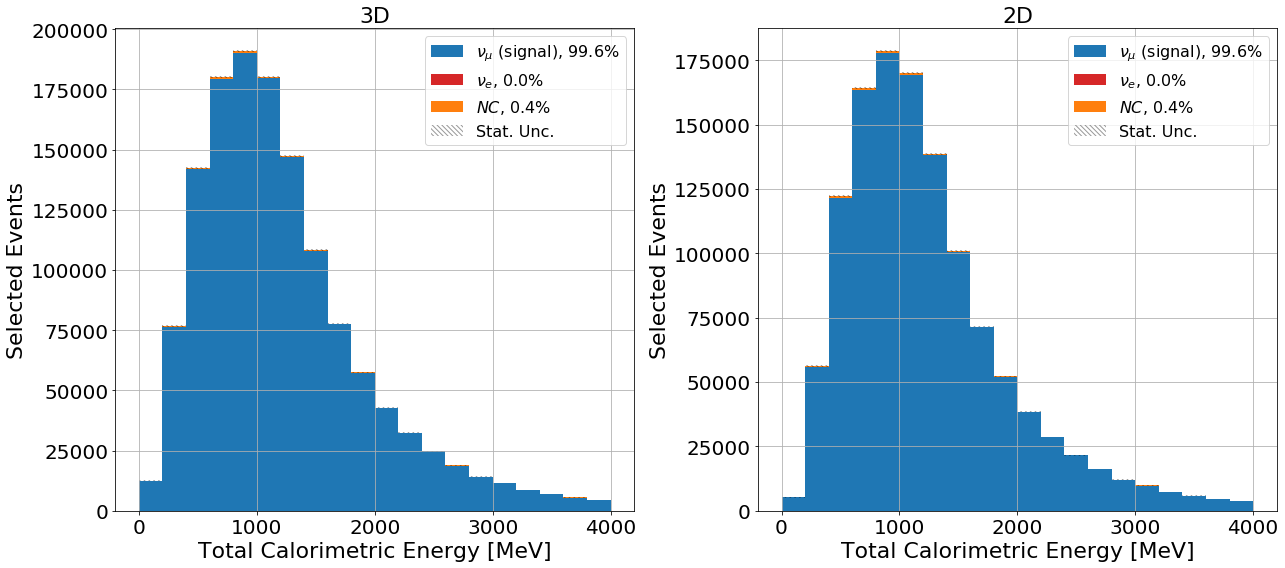

In [42]:
variable = 'tot_dep_e'
xlabel='Total Calorimetric Energy [MeV]'
x_range = [0, 4000]
n_bins = c['nbins']

to_plot_3d = []
to_plot_3d_w = []

to_plot_2d = []
to_plot_2d_w = []

# Add the signal (first histogram to be plotted)
to_plot_3d.append(sel_sig_df_3d[variable].values)
to_plot_3d_w.append(sel_sig_df_3d['pot'].values)

to_plot_2d.append(sel_sig_df_2d[variable].values)
to_plot_2d_w.append(sel_sig_df_2d['pot'].values)

# Add all the backgrounds (plotted stacked on top of signal)
for i, b in enumerate(c['bkgs_string']):
    to_plot_3d.append(sel_bkg_df_3d.query(b)[variable].values)
    to_plot_3d_w.append(sel_bkg_df_3d.query(b)['pot'].values)
    to_plot_2d.append(sel_bkg_df_2d.query(b)[variable].values)
    to_plot_2d_w.append(sel_bkg_df_2d.query(b)['pot'].values)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 8))

t_3d = plot_histogram(ax[0], to_plot_3d,
                      weights=to_plot_3d_w, 
                      n_bins=n_bins, limits=x_range, option='stacked',
                      label=c['all_labels'],
                      hcolors=c['colors'])

t_2d = plot_histogram(ax[1], to_plot_2d,
                      weights=to_plot_2d_w, 
                      n_bins=n_bins, limits=x_range, option='stacked',
                      label=c['all_labels'],
                      hcolors=c['colors'])

# Put first label element as last (stat unc.)
handles, labels = ax[0].get_legend_handles_labels()
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
ax[0].legend(handles,labels,fontsize=16, loc='best')

handles, labels = ax[1].get_legend_handles_labels()
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
ax[1].legend(handles,labels,fontsize=16, loc='best')

ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)

ax[0].set_xlabel(xlabel, fontsize=22)
ax[1].set_xlabel(xlabel, fontsize=22)

ax[0].set_ylabel('Selected Events', fontsize=22)
ax[1].set_ylabel('Selected Events', fontsize=22)

ax[0].set_title('3D', loc='center', fontsize=22)
ax[1].set_title('2D', loc='center', fontsize=22)

ax[0].grid(True)
ax[1].grid(True)

fig.tight_layout()


tot_3d = 0
tot_2d = 0
tot_bkg_3d = 0
tot_bkg_2d = 0

for i in range(len(t_3d)):
    tot_3d += t_3d[i]
    tot_2d += t_2d[i]
    if i != 0:
        tot_bkg_3d += t_3d[i]
        tot_bkg_2d += t_2d[i]
    
print ('3D - S/B = ', t_3d[0] / tot_bkg_3d)
print ('2D - S/B = ', t_2d[0] / tot_bkg_2d)
print ('3D - S/sqrt(S+B) = ', t_3d[0] / np.sqrt(tot_3d))
print ('2D - S/sqrt(S+B) = ', t_2d[0] / np.sqrt(tot_2d))

plt.savefig(c['folder']+'/sig_bkg_stacked_'+c['name']+'.pdf')
plt.show()

# Efficiency and Purity

In [43]:
def plot_eff_pur(ax, sel_sig_df, sig_df, sel_bkg_df, dim='3D', n_bins=8):
    
    # Construct the efficiency numerator and denominator
    eff_numerator = sel_sig_df[variable].values
    eff_numerator_w = sel_sig_df['pot'].values
    eff_denominator = sig_df[variable].values
    eff_denominator_w = sig_df['pot'].values

    # Construct the purity numerator and denominator,
    pur_numerator = sel_sig_df[variable].values
    pur_numerator_w = sel_sig_df['pot'].values
    pur_denominator = np.concatenate((sel_sig_df[variable].values, sel_bkg_df[variable].values))
    pur_denominator_w = np.concatenate((sel_sig_df['pot'].values, sel_bkg_df['pot'].values))

    eff, unc_low, unc_up, bins, bins_mid, unc_x = efficiency(num=eff_numerator, 
                                                             den=eff_denominator, 
                                                             num_w=eff_numerator_w, 
                                                             den_w=eff_denominator_w, 
                                                             n_bins=n_bins, 
                                                             limits=x_range)
    
    tot_eff, tot_err_eff, _, _, _, _ = efficiency(num=eff_numerator,den=eff_denominator,
                                                  num_w=eff_numerator_w,den_w=eff_denominator_w, 
                                                  n_bins=2,limits=x_range)
    if dim == '3D': 
        col = lighten_color(colors[2], 1.2)
        marker = 'o'
    else: 
        col = lighten_color(colors[2], 0.5)
        marker = 's'
        
    ax.errorbar(bins_mid, eff, 
                yerr=[unc_low, unc_up], xerr=unc_x,
                fmt=marker,
                color=col,
                label=dim+' - Efficiency = {0:0.3f} $\\pm$ {1:0.3f}'.format(tot_eff[0], tot_err_eff[0]))

    pur, unc_low, unc_up, bins, bins_mid, unc_x = efficiency(num=pur_numerator, 
                                                             den=pur_denominator, 
                                                             num_w=pur_numerator_w, 
                                                             den_w=pur_denominator_w, 
                                                             n_bins=n_bins, 
                                                             limits=x_range)

    tot_pur, tot_err_pur, _, _, _, _ = efficiency(num=pur_numerator,den=pur_denominator,
                                                  num_w=pur_numerator_w,den_w=pur_denominator_w, 
                                                  n_bins=2,limits=x_range)
    
    if dim == '3D': 
        col = lighten_color(colors[3], 1.2)
        marker = 'o'
    else: 
        col = lighten_color(colors[3], 0.5)
        marker = 's'
        
    ax.errorbar(bins_mid, pur, 
                yerr=[unc_low, unc_up], xerr=unc_x,
                fmt=marker,
                color=col,
                label=dim+' - Purity = {0:0.2f} $\\pm$ {1:0.2f}'.format(tot_pur[0], tot_err_pur[0]))

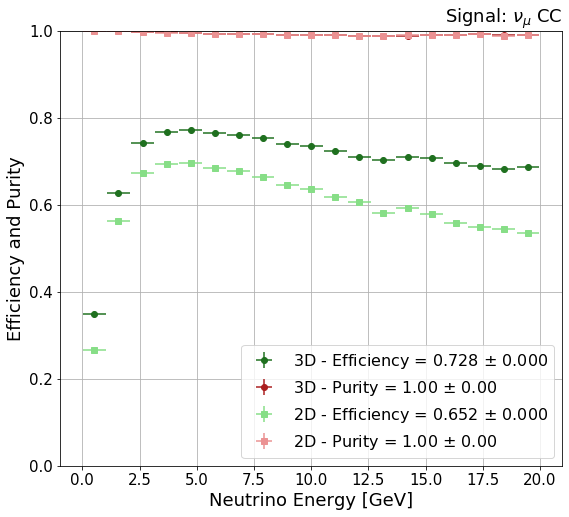

In [45]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,8))

variable = 'nu_e'
x_range = [0, 20]
# n_bins = 8

plot_eff_pur(ax, sel_sig_df_3d, sig_df_3d, sel_bkg_df_3d, dim='3D', n_bins=20)
plot_eff_pur(ax, sel_sig_df_2d, sig_df_2d, sel_bkg_df_2d, dim='2D', n_bins=20)

ax.legend(fontsize=16, loc='best')
plt.ylabel('Efficiency and Purity',fontsize=18)
ax.set_xlabel('Neutrino Energy [GeV]',fontsize=18)
plt.title('Signal: '+c['label'], loc='right', fontsize=18)
ax.tick_params(labelsize=15)
ax.set_ylim(0, 1)
plt.grid(True)

plt.savefig(c['folder']+'/eff_pur_2d_3d_'+c['name']+'.pdf')
plt.show()